design, implement, and evaluate a Convolutional Denoising
Autoencoder (CDAE) using a real-world dataset. The goal is to explore how CDAEs canremove noise from images while preserving their core features. This will deepen your understanding of convolutional neural networks (CNNs), autoencoders, and their applications in image denoising.

The Oxford-IIIT Pet Dataset includes over 7,000 images in 37 classes of
cats and dogs.:

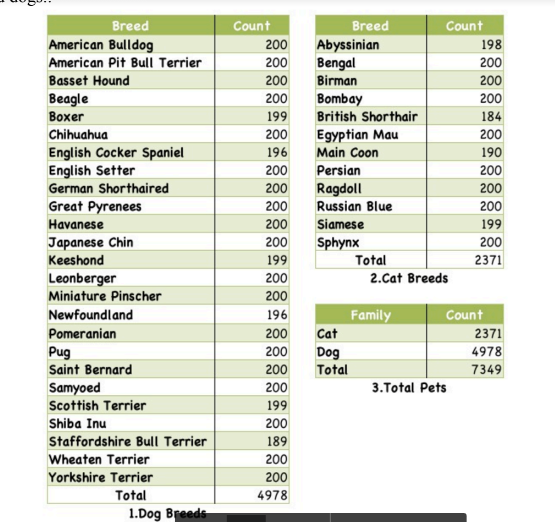

Using the Oxford-IIIT Pet Dataset, a diverse collection of images featuring 37 pet breeds.
This dataset is well-suited for exploring image denoising due to its variety in texture, color,
and shape. You can find anything you want about the dataset and download it through this
link :https://academictorrents.com/details/b18bbd9ba03d50b0f7f479acc9f4228a408cecc1

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

# Print the path to the dataset files
print("Path to dataset files:", path)


100%|██████████| 1.48G/1.48G [00:12<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1


In [7]:
import os
import zipfile

# Unzip the dataset if it is a .zip file
if path.endswith('.zip'):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extract_path = os.path.splitext(path)[0]
        zip_ref.extractall(extract_path)
        print("Dataset extracted to:", extract_path)


In [8]:
import tensorflow as tf

# Define path to images directory
data_dir = "/root/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1"

# Load the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128),
    batch_size=32
)

def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(normalize_img)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


Found 14779 files belonging to 1 classes.


In [19]:
import tensorflow as tf

def add_salt_and_pepper_noise(image, noise_level=0.05):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    noise = tf.random.uniform(shape=tf.shape(image), minval=0.0, maxval=1.0)
    noisy_image = tf.where(noise < noise_level / 2, 0.0, image)
    noisy_image = tf.where(noise > 1 - noise_level / 2, 1.0, noisy_image)
    return noisy_image
train_images = train_dataset.map(lambda img, label: (add_salt_and_pepper_noise(img), img))  # Noisy image as input, clean image as target
test_images = test_dataset.map(lambda img, label: (add_salt_and_pepper_noise(img), img))  # Noisy image as input, clean image as target


In [20]:
for noisy_image, clean_image in train_images.take(1):
    print("Noisy Image Shape:", noisy_image.shape)
    print("Clean Image Shape:", clean_image.shape)


Noisy Image Shape: (32, 128, 128, 3)
Clean Image Shape: (32, 128, 128, 3)


In [21]:
def build_encoder(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same")(x)
    return keras.Model(inputs, encoded, name="encoder")


In [22]:
def build_decoder(encoded_shape):
    inputs = keras.Input(shape=encoded_shape)
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    return keras.Model(inputs, decoded, name="decoder")


In [23]:
input_shape = (128, 128, 3)
encoded_shape = (16, 16, 16)
encoder = build_encoder(input_shape)
decoder = build_decoder(encoded_shape)

inputs = keras.Input(shape=input_shape)
encoded = encoder(inputs)
decoded = decoder(encoded)
autoencoder = keras.Model(inputs, decoded, name="autoencoder")


In [25]:
autoencoder.compile(optimizer="adam", loss="mse")


In [26]:
history = autoencoder.fit(
    train_images,
    validation_data=test_images,
    epochs=20,
    batch_size=32
)


Epoch 1/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 134s 226ms/step - loss: 0.0267 - val_loss: 0.0106
Epoch 2/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 87s 236ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 3/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0087

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-cf6480ce1a58>", line 1, in <cell line: 1>
    history = autoencoder.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 345, in fit
    val_logs = self.evaluate(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate
    logs = self.test_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return f

TypeError: object of type 'NoneType' has no len()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


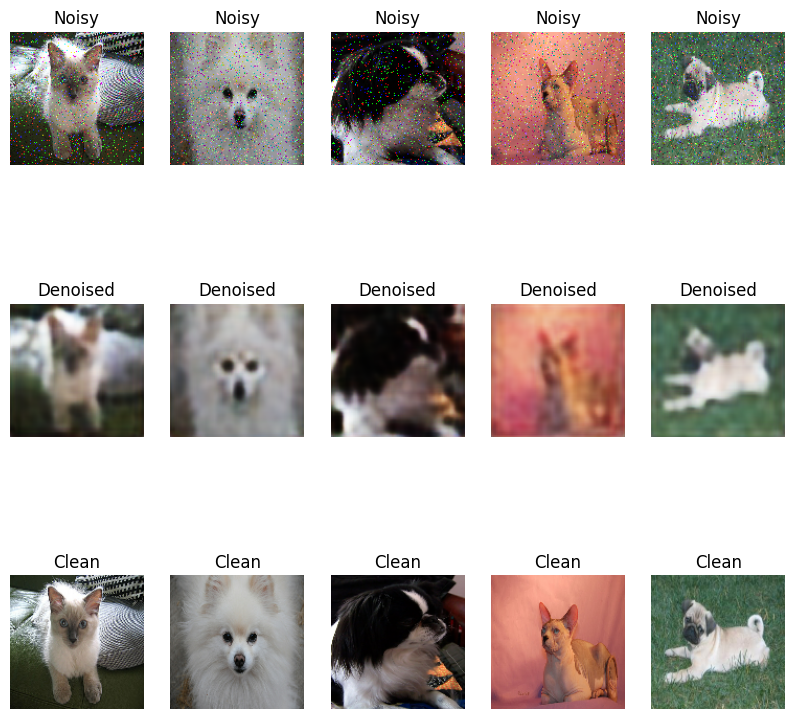

In [27]:
for noisy_image, clean_image in test_images.take(1):
    reconstructed = autoencoder.predict(noisy_image)
    plt.figure(figsize=(10, 10))
    for i in range(5):
        # Noisy
        plt.subplot(3, 5, i + 1)
        plt.imshow(noisy_image[i].numpy())
        plt.title("Noisy")
        plt.axis("off")

        # Reconstructed
        plt.subplot(3, 5, i + 6)
        plt.imshow(reconstructed[i])
        plt.title("Denoised")
        plt.axis("off")

        # Ground truth
        plt.subplot(3, 5, i + 11)
        plt.imshow(clean_image[i].numpy())
        plt.title("Clean")
        plt.axis("off")

    plt.show()
